In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
import pandas as pd


### Default image path

In [2]:
image_path = "images/hack2.png"

### Display image help function

In [3]:
def display_image(title, image):
    plt.figure(figsize=(8, 8))
    plt.title(title)
    plt.axis('off')
    if len(image.shape) == 2 or image.shape[2] == 1:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

## Basic reading image and display

Reading image from path: images/hack2.png


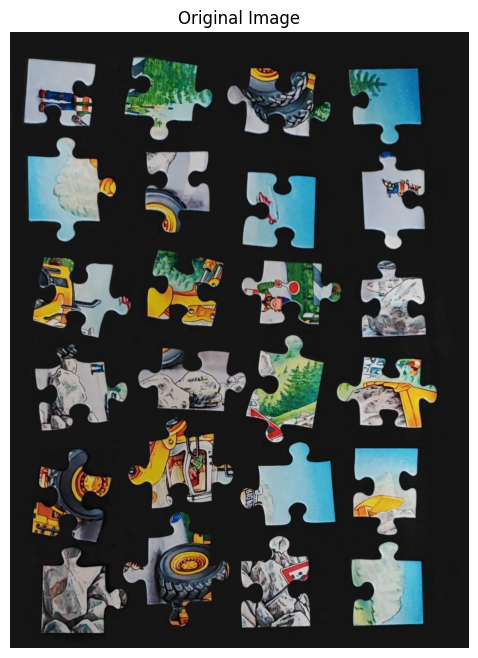

In [4]:
print("Reading image from path:", image_path)
original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
if original_image is None:
    raise ValueError(f"Could not read image from {image_path}")
display_image("Original Image", original_image)

## Grayscale conversion

Converting to grayscale


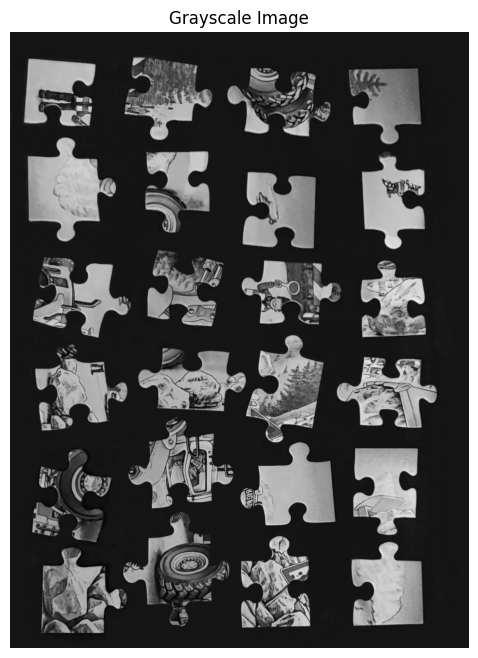

In [5]:
print("Converting to grayscale")
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
display_image("Grayscale Image", gray_image)

### Binary thresholding

Free parameters:
- threshold value: `30`
- maxval: `255`

Threshold to separate pieces from background


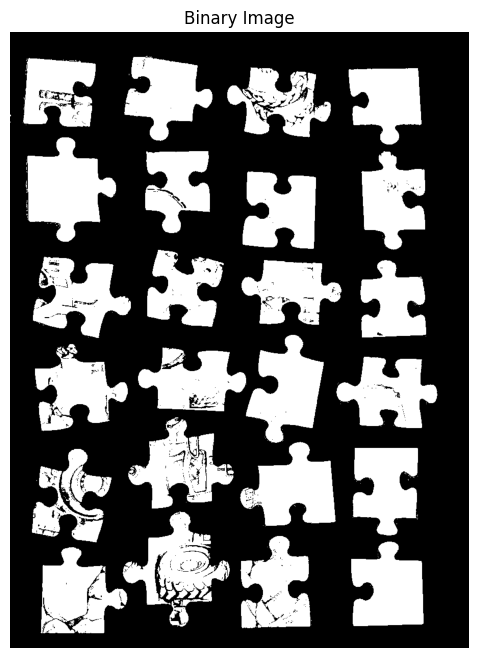

In [6]:
print("Threshold to separate pieces from background")
_, binary_image = cv2.threshold(gray_image, 30, 255, cv2.THRESH_BINARY)
display_image("Binary Image", binary_image)

## Morphing

Used to improve the shape and remove impurities

Free parameters:
- kernel ``(12,12)`` // like the size of the morphing

In [7]:
kernel = np.ones((12, 12), np.uint8)

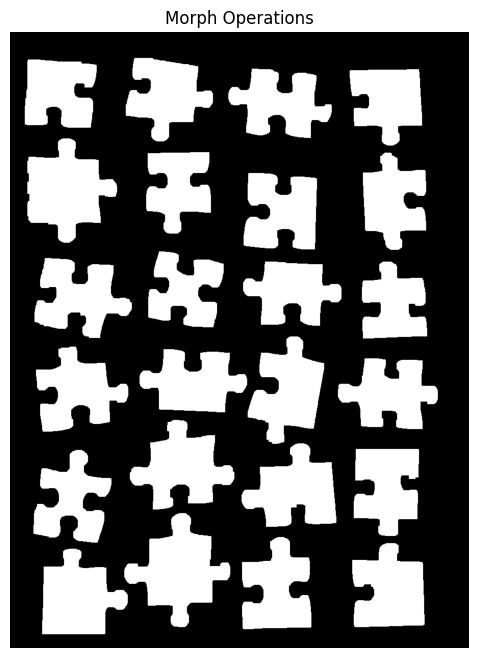

In [8]:
# Close = filling the holes
morph_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
# Open = removing the noise
morph_image = cv2.morphologyEx(morph_image, cv2.MORPH_OPEN, kernel)
display_image("Morph Operations", morph_image)

Filling holes in puzzle pieces


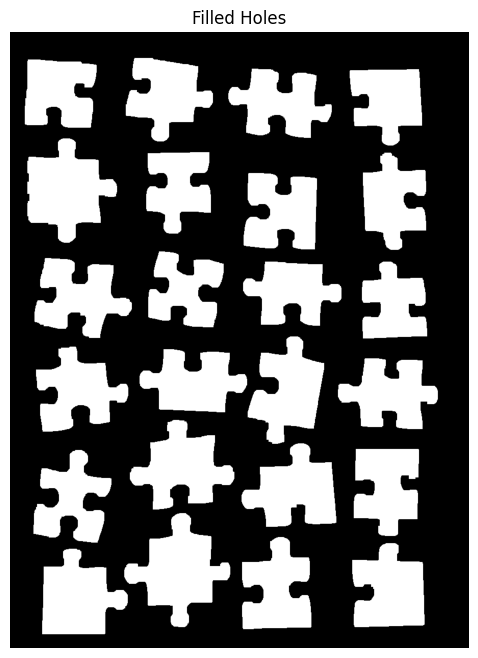

In [9]:
print("Filling holes in puzzle pieces")
contours_fill, _ = cv2.findContours(morph_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours_fill:
    cv2.drawContours(morph_image, [cnt], 0, 255, -1)
display_image("Filled Holes", morph_image)

## Contours finding

In [10]:
contours, _ = cv2.findContours(morph_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(f"Found {len(contours)} potential puzzle pieces")

Found 24 potential puzzle pieces


In [11]:
print("Filtering contours by size")
contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
if len(contours) > 1:
    reference_area = cv2.contourArea(contours[1])
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > reference_area / 3]
print(f"After filtering: {len(contours)} puzzle pieces")

Filtering contours by size
After filtering: 24 puzzle pieces


## Contours drawing

Free parameters:
- thickness: `2`
- rgb: `(0, 255, 0)`

Drawing contours of the original image


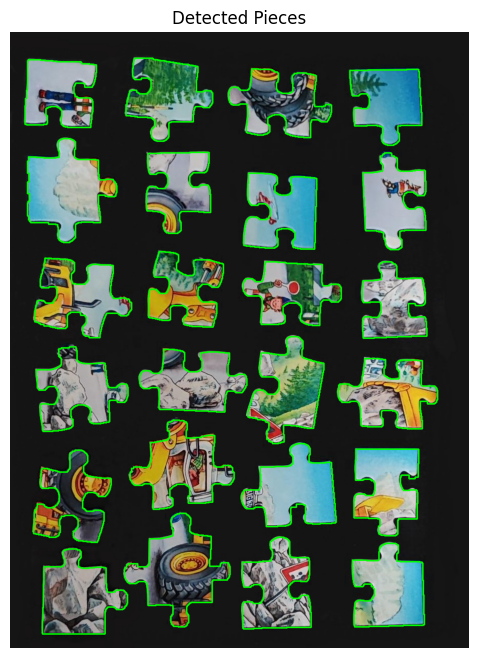

In [12]:
print("Drawing contours of the original image")
contour_image = original_image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
display_image("Detected Pieces", contour_image)

In [13]:
output_folder_pieces = "images/extracted_pieces"
os.makedirs(output_folder_pieces, exist_ok=True)

output_folder_contours = "images/extracted_contours"
os.makedirs(output_folder_contours, exist_ok=True)

output_corner_folder = "images/extracted_corners"
os.makedirs(output_corner_folder, exist_ok=True)

output_plots_folder = "images/corner_plots"
os.makedirs(output_plots_folder, exist_ok=True)

In [14]:
piece_images = []
for i, contour in enumerate(contours):
    mask = np.zeros_like(gray_image)
    cv2.drawContours(mask, [contour], 0, 255, -1)

    piece = np.zeros_like(original_image)
    piece[mask == 255] = original_image[mask == 255]

    x, y, w, h = cv2.boundingRect(contour)
    cropped_piece = piece[y:y + h, x:x + w]
    piece_images.append(cropped_piece)

    piece_path = os.path.join(output_folder_pieces, f"piece_{i + 1}.png")
    cv2.imwrite(piece_path, cropped_piece)

    # Save piece with contour
    contour_piece = cropped_piece.copy()
    mask_cropped = mask[y:y + h, x:x + w]
    cv2.drawContours(contour_piece, [contour - [x, y]], 0, (255, 0, 255), 1,
                     cv2.LINE_8)  # Pink, width 1, no anti-aliasing
    contour_path = os.path.join(output_folder_contours, f"contour_{i + 1}.png")
    cv2.imwrite(contour_path, contour_piece)

## Corners and Edges detection on single piece

In [15]:
selected_image_index = 6

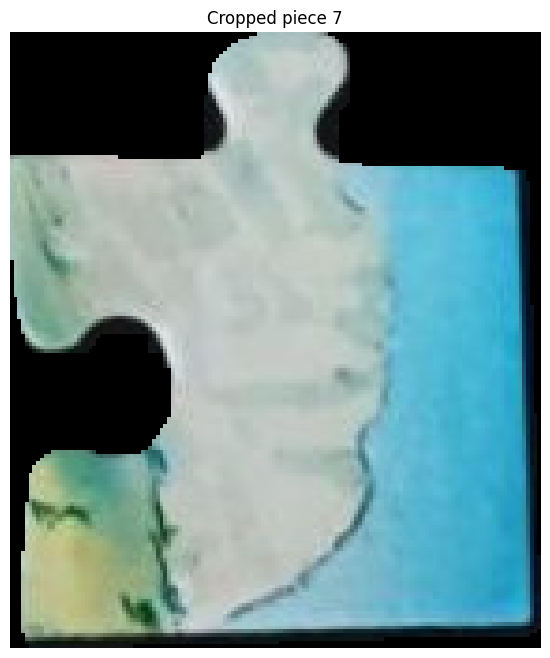

In [16]:
piece_images = []

i = selected_image_index
contour = contours[i]

mask = np.zeros_like(gray_image)
cv2.drawContours(mask, [contour], 0, 255, -1)

piece = np.zeros_like(original_image)
piece[mask == 255] = original_image[mask == 255]
x, y, w, h = cv2.boundingRect(contour)
cropped_piece = piece[y:y + h, x:x + w]
piece_images.append(cropped_piece)

piece_path = os.path.join(output_folder_pieces, f"piece_{i + 1}.png")
cv2.imwrite(piece_path, cropped_piece)
contour_piece = cropped_piece.copy()

display_image(f"Cropped piece {i+1}", contour_piece)


## Find the piece center

Free parameters:
- thickness: `2`
- rgb: `(0, 0, 255)`
- circle pos: $(cx, cy)

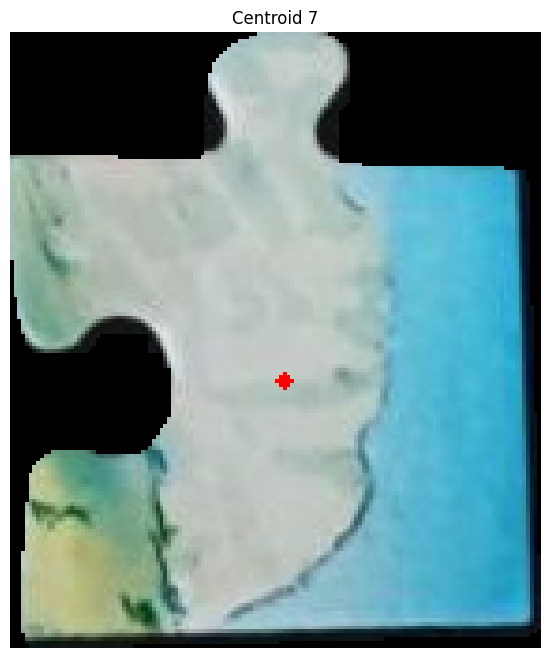

In [17]:
M = cv2.moments(contour)

if M["m00"] == 0:
    print("ERROR")
centroid_x = int(M["m10"] / M["m00"])
centroid_y = int(M["m01"] / M["m00"])
cv2.circle(contour_piece, (centroid_x - x, centroid_y - y), 2, (0, 0, 255), -1)
display_image(f"Centroid {i+1}", contour_piece)

## Rainbow contour ( for testing )

In [18]:
def rainbow_color(t):
    t = t % 256  # wrap around after 255
    phase = t / 256 * 6
    x = int(255 * (1 - abs(phase % 2 - 1)))
    if phase < 1:     return (255, x, 0)       # Red → Yellow
    elif phase < 2:   return (x, 255, 0)       # Yellow → Green
    elif phase < 3:   return (0, 255, x)       # Green → Cyan
    elif phase < 4:   return (0, x, 255)       # Cyan → Blue
    elif phase < 5:   return (x, 0, 255)       # Blue → Magenta
    else:             return (255, 0, x)

671 1004


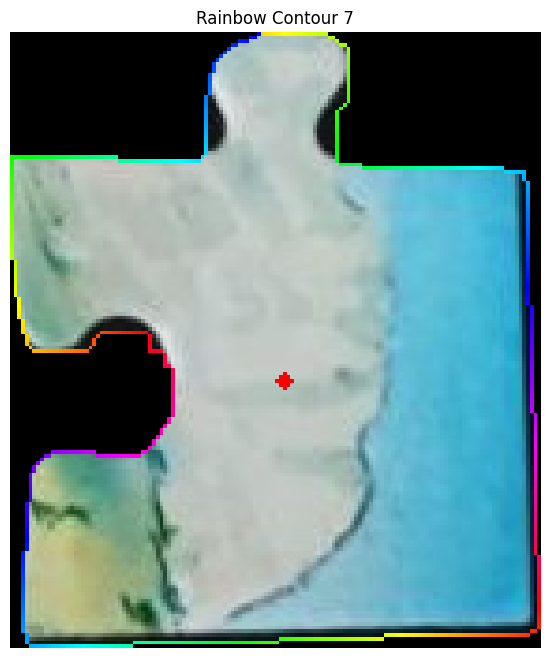

In [19]:
rainbow_piece = contour_piece.copy()

print(x, y)

contour_points = contour - np.array([x, y])
counter = 0
for point in contour:

    px, py = point[0]
    rainbow_piece[py - y, px -  x] = (rainbow_color(counter))
    counter += 1

display_image(f"Rainbow Contour {i+1}", rainbow_piece)


## Transform the contour into polar coordinates

***Note: inverted angles in the plot -> for clockwise plot***

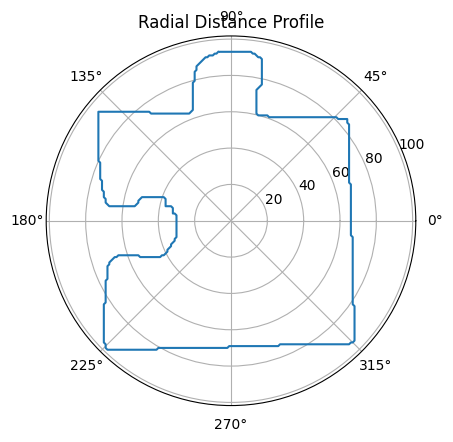

In [20]:
contour_points = contour - np.array([x, y])
distances = []
angles = []
for point in contour:
    px, py = point[0]
    dx = px - centroid_x
    dy = py - centroid_y
    distance = np.sqrt(dx ** 2 + dy ** 2)
    angle = np.arctan2(dy, dx)
    distances.append(distance)
    angles.append(angle)

angles_deg = np.array([(a * 180 / np.pi) % 360 for a in angles])

plt.polar(-np.array(angles), distances)
plt.title("Radial Distance Profile")
plt.show()

free parameters:
- marker: `.`

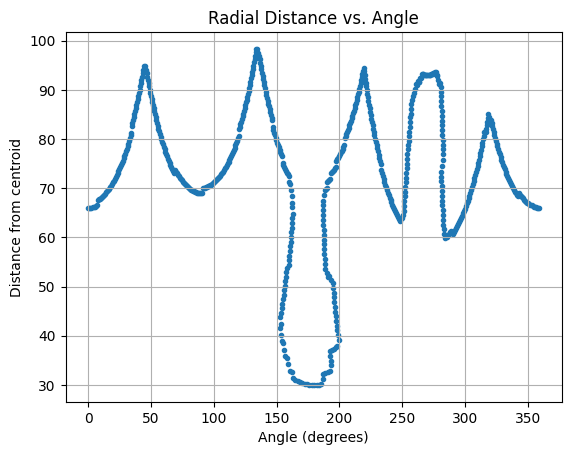

In [21]:
plt.style.use('default')
plt.scatter(angles_deg, distances, marker='.')
plt.xlabel("Angle (degrees)")
plt.ylabel("Distance from centroid")
plt.title("Radial Distance vs. Angle")
plt.grid(True)
plt.show()

## Peaks detection

Free parameters:
- ``min_distance_between_peaks``
- ``prominence``

In [22]:
# find the maxima
min_distance_between_peaks = len(distances) // 10
print(min_distance_between_peaks, len(distances)) # for data analysis
all_peak_indices, all_peak_properties = find_peaks(distances,                                 distance=min_distance_between_peaks,prominence=0.1)

peak_angles = [angles_deg[peak_idx] for peak_idx in all_peak_indices]
peak_distances = [distances[peak_idx] for peak_idx in all_peak_indices]

# find the minima
inverted_distances = [-d for d in distances]
all_min_indices, all_min_properties = find_peaks(inverted_distances,
                                 distance=min_distance_between_peaks,prominence=0.1)

min_angles = [angles_deg[min_idx] for min_idx in all_min_indices]
min_distances = [distances[min_idx] for min_idx in all_min_indices]

min_distances_avg = np.mean(min_distances)

64 647


### Peaks table display

note: before etra peak removal


In [23]:
df = pd.DataFrame({
    'Index': all_peak_indices,         # Peak indices
    'Angle (degrees)': peak_angles,    # Peak angles
    'Distance': peak_distances         # Peak distances
})

df

,Index,Angle (degrees),Distance
0,88,219.417394,94.493386
1,157,192.171458,52.172790
2,285,133.763592,98.310732
3,421,44.144903,94.762862
4,543,318.814075,85.041167
5,629,276.745580,93.648278


## Minima table display

In [24]:
df2 = pd.DataFrame({
    'Index': all_min_indices,         # Peak indices
    'Angle (degrees)': min_angles,    # Peak angles
    'Distance': min_distances         # Peak distances
})

df2

,Index,Angle (degrees),Distance
0,38,248.702646,63.324561
1,188,180.000000,30.000000
2,353,90.000000,69.000000
3,487,0.000000,66.000000
4,592,284.500167,59.908263


## Remove the extra peaks

Free parameters:
- ``max_angle_diff``

In [25]:
max_angle_diff = 25
delCounter = 0

remaining_peak_indices = all_peak_indices.tolist() if isinstance(all_peak_indices, np.ndarray) else all_peak_indices.copy()
remaining_peak_angles = peak_angles.tolist() if isinstance(peak_angles, np.ndarray) else peak_angles.copy()
remaining_peak_distances = peak_distances.tolist() if isinstance(peak_distances, np.ndarray) else peak_distances.copy()

while True:
    removals_made = False

    for k in range(len(remaining_peak_angles)):
        if len(remaining_peak_angles) <= 1:
            break

        if remaining_peak_distances[k] <= min_distances_avg:
            print("removing a bottom peak")
            remaining_peak_indices.pop(k)
            remaining_peak_angles.pop(k)
            remaining_peak_distances.pop(k)
            break


        next_k = (k + 1) % len(remaining_peak_angles)  # Wrap-around logic

        if abs(remaining_peak_angles[next_k] - remaining_peak_angles[k]) < max_angle_diff:
            delCounter += 1
            removals_made = True

            if remaining_peak_distances[k] < remaining_peak_distances[next_k]:
                remaining_peak_indices.pop(k)
                remaining_peak_angles.pop(k)
                remaining_peak_distances.pop(k)
            else:
                remaining_peak_indices.pop(next_k)
                remaining_peak_angles.pop(next_k)
                remaining_peak_distances.pop(next_k)

            break


    if not removals_made or len(remaining_peak_angles) <= 1:
        break

all_peak_indices = np.array(remaining_peak_indices) if isinstance(all_peak_indices, np.ndarray) else remaining_peak_indices
peak_angles = np.array(remaining_peak_angles) if isinstance(peak_angles, np.ndarray) else remaining_peak_angles
peak_distances = np.array(remaining_peak_distances) if isinstance(peak_distances, np.ndarray) else remaining_peak_distances

# Print out the result
print(f"We deleted {delCounter} extra peak angles")

removing a bottom peak
We deleted 0 extra peak angles


## Drawing the maxima

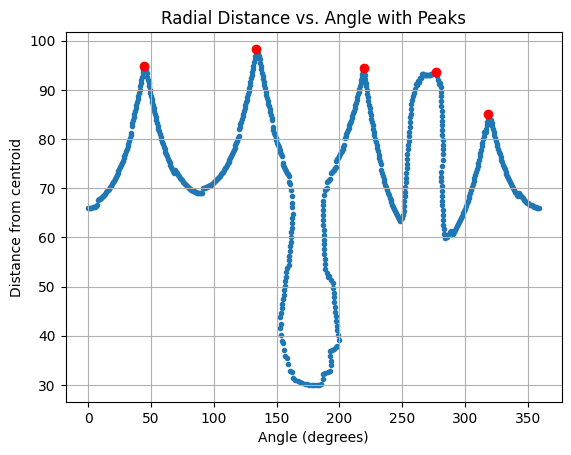

In [26]:
plt.style.use('default')
plt.scatter(angles_deg, distances, marker='.')
plt.scatter(peak_angles, peak_distances, color='red', marker='o', label='Peaks')
plt.xlabel("Angle (degrees)")
plt.ylabel("Distance from centroid")
plt.title("Radial Distance vs. Angle with Peaks")
plt.grid(True)
plt.show()

## Drawing the minima

In [27]:
print(all_min_indices)
print(min_distances_avg)

[ 38 188 353 487 592]
57.64656479979018


In [28]:
new_min_indice = []

for min_indice in all_min_indices:
    if distances[min_indice] < min_distances_avg:
        new_min_indice.append(min_indice)

all_min_indices = np.array(new_min_indice)


In [29]:
min_angles = [angles_deg[min_idx] for min_idx in new_min_indice]
min_distances = [distances[min_idx] for min_idx in new_min_indice]

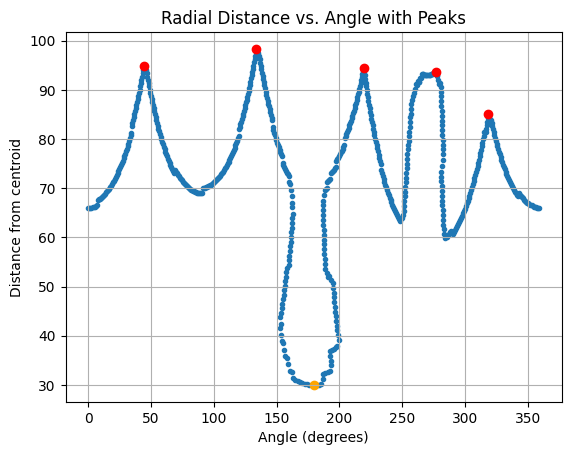

In [30]:
plt.style.use('default')
plt.scatter(angles_deg, distances, marker='.')
plt.scatter(peak_angles, peak_distances, color='red', marker='o', label='Peaks')
plt.scatter(min_angles, min_distances, color='orange', marker='o', label='Minima')
plt.xlabel("Angle (degrees)")
plt.ylabel("Distance from centroid")
plt.title("Radial Distance vs. Angle with Peaks")
plt.grid(True)
plt.show()

# [52 146 255 385 464 565 655]

## Find the 4 corners

They are defined as the top4 most pointy minima

[ 88 285 421 543 629]
[0, 1, 2, 3]
[np.int64(88), np.int64(285), np.int64(421), np.int64(543)]
[88, 285, 421, 543]
[np.int64(629)]
[np.float64(219.41739424346892), np.float64(133.76359239714384), np.float64(44.14490260373328), np.float64(318.81407483429035)]
[np.float64(94.49338601193207), np.float64(98.3107318658548), np.float64(94.76286192385707), np.float64(85.0411665018772)]


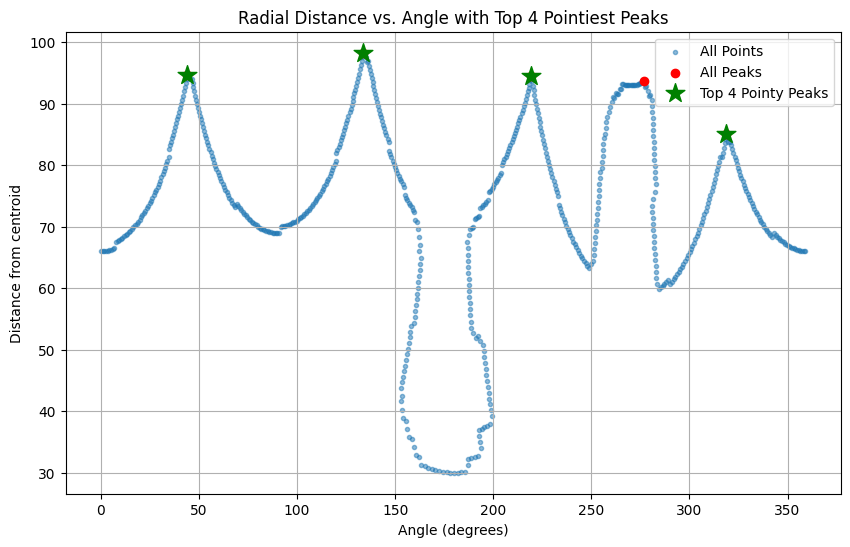

Peak 1: Angle = 219.42°, Distance = 94.49, Pointiness = 17.35
Peak 2: Angle = 133.76°, Distance = 98.31, Pointiness = 14.54
Peak 3: Angle = 44.14°, Distance = 94.76, Pointiness = 14.57
Peak 4: Angle = 318.81°, Distance = 85.04, Pointiness = 13.65
Peak 5: Angle = 276.75°, Distance = 93.65, Pointiness = 5.95

Top 4 pointiest peaks:
Peak 1: Angle = 219.42°, Distance = 94.49, Pointiness = 17.35
Peak 2: Angle = 133.76°, Distance = 98.31, Pointiness = 14.54
Peak 3: Angle = 44.14°, Distance = 94.76, Pointiness = 14.57
Peak 4: Angle = 318.81°, Distance = 85.04, Pointiness = 13.65


In [31]:
def robust_pointiness(angles_deg, distances, peak_indices, window_small=5, window_large=15):
    pointiness_scores = []

    for peak_idx in peak_indices:
        small_left = max(0, peak_idx - window_small)
        small_right = min(len(distances) - 1, peak_idx + window_small)
        small_window = distances[small_left:small_right+1]

        large_left = max(0, peak_idx - window_large)
        large_right = min(len(distances) - 1, peak_idx + window_large)
        large_window = distances[large_left:large_right+1]

        peak_height = distances[peak_idx]
        small_avg = np.mean(small_window)
        large_avg = np.mean(large_window)

        pointiness = (peak_height - large_avg) * (small_avg - large_avg)
        pointiness_scores.append(pointiness)

    return pointiness_scores

pointiness_scores = robust_pointiness(angles_deg, distances, all_peak_indices)

top_4_indices = sorted(range(len(pointiness_scores)),
                      key=lambda i: pointiness_scores[i],
                      reverse=True)[:4]

top_4_indices = sorted(top_4_indices)
top_4_peak_indices = [all_peak_indices[i] for i in top_4_indices]

temp = [int(w) for w in top_4_peak_indices]
remaining_indices = [z for z in all_peak_indices if z not in temp]

top_4_angles = [angles_deg[i] for i in top_4_peak_indices]
top_4_distances = [distances[i] for i in top_4_peak_indices]

print(all_peak_indices)
print(top_4_indices)
print(top_4_peak_indices)
print(temp)
print(remaining_indices)
print(top_4_angles)
print(top_4_distances)

plt.figure(figsize=(10, 6))
plt.scatter(angles_deg, distances, marker='.', alpha=0.5, label='All Points')
plt.scatter(peak_angles, peak_distances, color='red', marker='o', label='All Peaks')
plt.scatter(top_4_angles, top_4_distances, color='green', marker='*', s=200, label='Top 4 Pointy Peaks')
plt.xlabel("Angle (degrees)")
plt.ylabel("Distance from centroid")
plt.title("Radial Distance vs. Angle with Top 4 Pointiest Peaks")
plt.legend()
plt.grid(True)
plt.show()

# Print pointiness scores for all peaks
for i, (angle, distance, score) in enumerate(zip(peak_angles, peak_distances, pointiness_scores)):
    print(f"Peak {i+1}: Angle = {angle:.2f}°, Distance = {distance:.2f}, Pointiness = {score:.2f}")
print("\nTop 4 pointiest peaks:")
for i, idx in enumerate(top_4_indices):
    print(f"Peak {idx+1}: Angle = {peak_angles[idx]:.2f}°, Distance = {peak_distances[idx]:.2f}, Pointiness = {pointiness_scores[idx]:.2f}")

## Draw the 4 corners

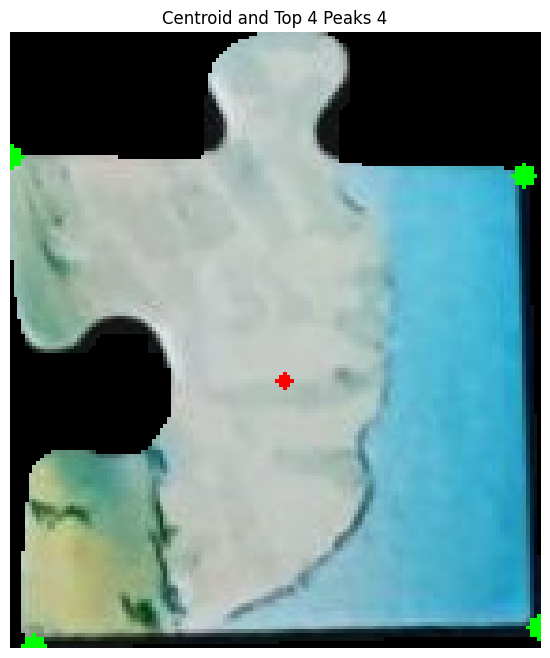

Peak coordinates (x, y):
Peak 1: (0, 33)
Peak 2: (6, 164)
Peak 3: (141, 159)
Peak 4: (137, 38)


In [32]:
contour_piece_with_peaks = contour_piece.copy()

cv2.circle(contour_piece_with_peaks, (centroid_x - x, centroid_y - y), 2, (0, 0, 255), -1)

peak_coords = []
for angle, distance in zip(top_4_angles, top_4_distances):
    angle_rad = np.radians(angle)

    dx = int(distance * np.cos(angle_rad))
    dy = int(distance * np.sin(angle_rad))

    peak_x = (centroid_x - x) + dx
    peak_y = (centroid_y - y) + dy

    cv2.circle(contour_piece_with_peaks, (peak_x, peak_y), 3, (0, 255, 0), -1)
    peak_coords.append((peak_x, peak_y))

display_image(f"Centroid and Top 4 Peaks {i+1}", contour_piece_with_peaks)

print("Peak coordinates (x, y):")
for idx, (px, py) in enumerate(peak_coords):
    print(f"Peak {idx+1}: ({px}, {py})")

In [33]:
class puzzlePiece:
    def __init__(self, piece_id, contour, peaks_ids, center, angles, distances):
        self.piece_id = piece_id
        self.contour = contour
        self.corners = peaks_ids
        self.center = center
        self.contour_polar = (angles, distances)
        self.edges = []

    def __repr__(self):
        ret = ""
        ret += f"{self.piece_id}\n"
        ret += f"Contour: {len(self.contour)}\n"
        ret += f"Corners: {self.corners}\n"

        return ret

puzzle_pieces_holder = {}

this_piece = puzzlePiece(
    1,
    contour,
    top_4_peak_indices,
    (centroid_x - x, centroid_y - y),
    angles_deg,
    distances
)

print(this_piece)


1
Contour: 647
Corners: [np.int64(88), np.int64(285), np.int64(421), np.int64(543)]



## Edge type detection

In [34]:
def exists_peak_between(a,b,peak_indices):
    if b < a:
        for p in peak_indices:
            if p > a or p < b:
                return True

    else:
        for p in peak_indices:
            if p > a and p < b:
                return True

        print("no peak between")
        return False

In [35]:
def exists_minima_between(a,b,min_indices):
    if b < a:
        for p in min_indices:
            if p > a or p < b:
                return True

    else:
        for p in min_indices:
            if p > a and p < b:
                return True

        print("no min between")
        return False

In [36]:
edge_types = {0: "FLAT", 1: "IN", 2: "OUT"}
print(remaining_indices)
print(all_min_indices)

def get_edge_type(a, b):
    if exists_peak_between(a, b, remaining_indices):
        return 2
    else:
        if exists_minima_between(a, b, all_min_indices):
            return 1
        else:
            return 0


[np.int64(629)]
[188]


In [37]:
class Edge:
    def __init__(self, edge_type, left_corner, right_corner):
        self.edge_type = edge_type
        self.left_corner = left_corner
        self.right_corner = right_corner


In [38]:
edges = []

for c, corner in enumerate(top_4_peak_indices):
    corner1 = top_4_peak_indices[c]
    corner2 = top_4_peak_indices[(c+1) % len(top_4_peak_indices)]

    edges.append((c, corner1, corner2, get_edge_type(corner1, corner2)))

this_piece.edges = edges

print(edges)

no peak between
no peak between
no min between
no peak between
no min between
[(0, np.int64(88), np.int64(285), 1), (1, np.int64(285), np.int64(421), 0), (2, np.int64(421), np.int64(543), 0), (3, np.int64(543), np.int64(88), 2)]


In [39]:
for edge_id, start_idx, end_idx, edge_type in edges:
    print(angles_deg[start_idx], angles_deg[end_idx])

219.41739424346892 133.76359239714384
133.76359239714384 44.14490260373328
44.14490260373328 318.81407483429035
318.81407483429035 219.41739424346892


## Draw edges in a different color ( testing )

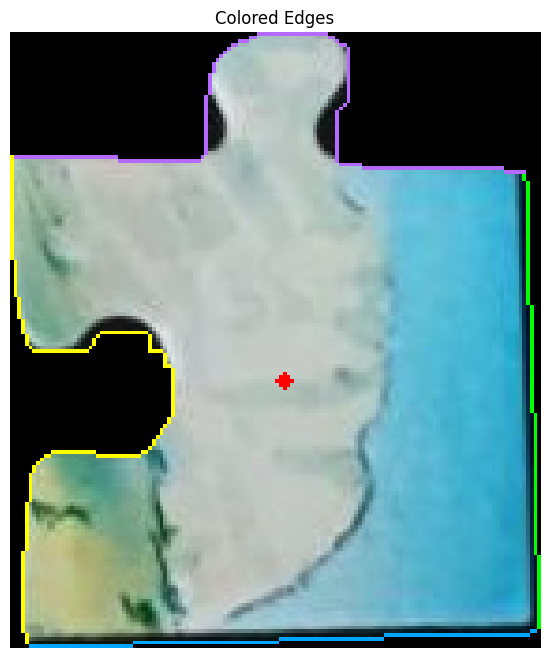

In [40]:
color_edge_piece = contour_piece.copy()

contour_points = contour.reshape(-1, 2)
contour_points_shifted = contour_points - np.array([x, y])  # apply shift

edge_colors = [
    (0, 255, 255),   # Cyan
    (255, 165, 0),   # Orange
    (0, 255, 0),     # Green
    (255, 105, 180)  # Pink
]

for edge_id, start_idx, end_idx, edge_type in edges:
    color = edge_colors[edge_id]
    if start_idx < end_idx:
        indices = range(start_idx, end_idx)
    else:
        indices = list(range(start_idx, len(contour_points))) + list(range(0, end_idx))

    for idx in indices:
        px, py = contour_points_shifted[idx]
        color_edge_piece[py, px] = color

display_image(f"Colored Edges", color_edge_piece)


## Draw edges types with Corners

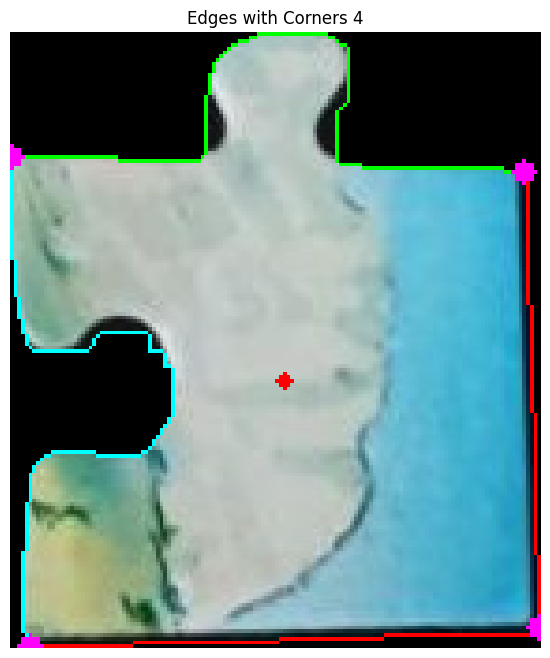

In [41]:
color_edge_corner_piece = contour_piece.copy()

contour_points = contour.reshape(-1, 2)
contour_points_shifted = contour_points - np.array([x, y])  # apply shift

edge_colors = {
    0: (0, 0, 255),   # Blue for edge_type 0
    1: (255, 255, 0), # Yellow for edge_type 1
    2: (0, 255, 0)    # Green for edge_type 2
}

corner_color = (255, 0, 255)  # Purple color for corners
for edge_id, start_idx, end_idx, edge_type in edges:
    start_px, start_py = contour_points[start_idx] - np.array([x, y])
    end_px, end_py = contour_points[end_idx] - np.array([x, y])

    color = edge_colors[edge_type]
    if start_idx < end_idx:
        indices = range(start_idx, end_idx)
    else:
        indices = list(range(start_idx, len(contour_points))) + list(range(0, end_idx))

    for idx in indices:
        px, py = contour_points_shifted[idx]
        color_edge_corner_piece[py, px] = color

    cv2.circle(color_edge_corner_piece, (start_px, start_py), 3, corner_color, -1)  # Start corner
    cv2.circle(color_edge_corner_piece, (end_px, end_py), 3, corner_color, -1)    # End corner

display_image(f"Edges with Corners {i+1}", color_edge_corner_piece)
